In [2]:
# !apt update
# !apt-get install git-lfs
# !git lfs install
# !mkdir ../vton_origin
# !git clone https://huggingface.co/spaces/yisol/IDM-VTON ../vton_origin
# !rm -rf ../vton_origin/.git/
# !rm -rf ../vton_origin/example/
# !apt-get install rsync
# !rsync -av --ignore-existing vton_origin/ VTO_demo/
# !pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121
# !pip install -r requirements.txt

In [1]:
!nvidia-smi

Sat Sep 21 21:56:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:02:00.0 Off |                  Off |
|  0%   28C    P8             29W /  450W |   15586MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import sys
import cv2
import json
import matplotlib.pyplot as plt
import gradio as gr
from PIL import Image
from src.tryon_pipeline import StableDiffusionXLInpaintPipeline as TryonPipeline
from src.unet_hacked_garmnet import UNet2DConditionModel as UNet2DConditionModel_ref
from src.unet_hacked_tryon import UNet2DConditionModel
from transformers import (
    CLIPImageProcessor,
    CLIPVisionModelWithProjection,
    CLIPTextModel,
    CLIPTextModelWithProjection,
)
from diffusers import DDPMScheduler,AutoencoderKL
from typing import List

import torch
import os
from transformers import AutoTokenizer
import numpy as np
from utils_mask import get_mask_location
from torchvision import transforms
import apply_net
from preprocess.humanparsing.run_parsing import Parsing
from preprocess.openpose.run_openpose import OpenPose
from detectron2.data.detection_utils import convert_PIL_to_numpy,_apply_exif_orientation
from torchvision.transforms.functional import to_pil_image

Im = Image.fromarray
pi = plt.imshow

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [62]:
from PIL import Image, ImageChops, ImageFilter

import torch
import numpy as np

from utils_mask import get_mask_location
from torchvision import transforms
import apply_net

from detectron2.data.detection_utils import convert_PIL_to_numpy,_apply_exif_orientation
from torchvision.transforms.functional import to_pil_image
from segmentation_processor import request_segmentation_results, extract_submask

def correct_masking(preserve_mask, org_image, mask, mask_gray):
    preserve_mask = Image.fromarray(preserve_mask).convert('L')
    mask2_inverted = ImageChops.invert(preserve_mask)
    corrected_mask = ImageChops.multiply(mask, mask2_inverted)
    corrected_mask_gray = Image.composite(org_image, mask_gray, preserve_mask)
    return corrected_mask, corrected_mask_gray


def erose_mask(mask, kernal_size=11):
    eroded_mask = binary_erosion(
        mask,
        structure = np.ones((kernal_size, kernal_size), dtype=np.uint8),
        iterations=1
    )
    return eroded_mask.astype(mask.dtype)

In [3]:
import yaml
from pipeline_loader import PipelineLoader

with open('pipeline_config.yaml', 'r') as file:
    pipeline_config = yaml.safe_load(file)


pipeline_loader = PipelineLoader(
    base_path=pipeline_config['base_path'],
    device=pipeline_config['device']
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
Some weights of the model checkpoint were not used when initializing UNet2DConditionModel: 
 ['add_embedding.linear_1.bias, add_embedding.linear_1.weight, add_embedding.linear_2.bias, add_embedding.linear_2.weight']
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_

Loading pipeline components...:   0%|          | 0/8 [00:00<?, ?it/s]

In [64]:
class TryOnProcessor:
    def __init__(self, pipeline_config, pipeline_loader):
        self.pipeline_config = pipeline_config
        self.segmentaion_config = self.pipeline_config['segmentaion']
        self.device = pipeline_config['device']
        self.pipe = pipeline_loader.get_pipeline()
        self.openpose_model = pipeline_loader.get_openpose_model()
        self.parsing_model = pipeline_loader.get_parsing_model()
        self.tensor_transform = pipeline_loader.get_tensor_transform()

    def to(self, device):
        self.pipe.to(device)

    def preprocess_submasks(self, init_image):
        init_segmentation_map, init_classes_mapping = request_segmentation_results(
            url=self.segmentaion_config['service_url'], 
            image=init_image
        )

        pre_preservation_classes = extract_submask(
            segmentation_map=init_segmentation_map,
            submask_classes=self.segmentaion_config['pre_preservation_classes'],
            classes_mapping=init_classes_mapping
        )

        pre_preservation_classes = erose_mask(pre_preservation_classes)

        return pre_preservation_classes, init_segmentation_map, init_classes_mapping
        

    def postprocess_submasks(
        self, 
        init_image, 
        init_segmentation_map,
        init_classes_mapping, 
        result_image,
        blur_radius=11,
    ):
        segmentaion_config = self.segmentaion_config

        soft_preservation_submask = extract_submask(
            segmentation_map=init_segmentation_map,
            submask_classes=segmentaion_config['soft_preservation_classes'],
            classes_mapping=init_classes_mapping
        )

        force_preservetion_submask = extract_submask(
            segmentation_map=init_segmentation_map,
            submask_classes=segmentaion_config['force_preservation_classes'],
            classes_mapping=init_classes_mapping
        )

        result_segmentation_map, result_classes_mapping = request_segmentation_results(
            url=segmentaion_config['service_url'], 
            image=result_image
        )

        clothing_submask = extract_submask(
            segmentation_map=result_segmentation_map,
            submask_classes=segmentaion_config['clothing_classes'],
            classes_mapping=result_classes_mapping
        )

        Image.fromarray(clothing_submask).convert("L").save('clothing_submask.png')

        force_mask = Image.fromarray(force_preservetion_submask).convert("L")
        force_mask = force_mask.filter(ImageFilter.GaussianBlur(radius=blur_radius))
        composed_image = Image.composite(init_image, result_image, force_mask)

        soft_mask = np.logical_and(
            soft_preservation_submask, 
            np.logical_not(clothing_submask)
        )
        soft_mask_pil = Image.fromarray(soft_mask).convert("L")
        soft_mask_pil = soft_mask_pil.filter(ImageFilter.GaussianBlur(radius=blur_radius))

        composed_image = Image.composite(init_image, composed_image, soft_mask_pil)
        return composed_image


    def preprocess_images(self, human_canva, garm_img):
        garm_img = garm_img.convert("RGB").resize((768, 1024))
        human_img_orig = human_canva["background"].convert("RGB")
        human_img = human_img_orig.resize((768, 1024))
        return garm_img, human_img, human_img_orig

    def generate_keypoints_and_parse_model(self, human_img):
        resized_human_img = human_img.resize((384, 512))
        keypoints = self.openpose_model(resized_human_img)
        model_parse, _ = self.parsing_model(resized_human_img)
        return keypoints, model_parse

    def generate_mask_and_mask_gray(self, model_parse, keypoints, human_img):
        mask, mask_gray = get_mask_location('hd', "upper_body", model_parse, keypoints)
        mask = mask.resize((768, 1024))
        mask_gray = (1 - transforms.ToTensor()(mask)) * self.tensor_transform(human_img)
        mask_gray = to_pil_image((mask_gray + 1.0) / 2.0)
        return mask, mask_gray

    def prepare_human_image_for_pose_estimation(self, human_img):
        human_img_arg = _apply_exif_orientation(human_img.resize((384, 512)))
        human_img_arg = convert_PIL_to_numpy(human_img_arg, format="BGR")
        return human_img_arg

    def generate_pose_image(self, human_img_arg):
        argument_parser = apply_net.create_argument_parser()
        args = argument_parser.parse_args(
            (
                'show',
                './configs/densepose_rcnn_R_50_FPN_s1x.yaml',
                './ckpt/densepose/model_final_162be9.pkl',
                'dp_segm', '-v', '--opts', 'MODEL.DEVICE', self.device
            )
        )
        pose_img = args.func(args, human_img_arg)
        pose_img = pose_img[:, :, ::-1]
        pose_img = Image.fromarray(pose_img).resize((768, 1024))
        return pose_img

    def encode_prompts(self, garment_des):
        prompt = "model is wearing " + garment_des
        negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"
        with torch.inference_mode():
            (
                prompt_embeds,
                negative_prompt_embeds,
                pooled_prompt_embeds,
                negative_pooled_prompt_embeds,
            ) = self.pipe.encode_prompt(
                prompt,
                num_images_per_prompt=1,
                do_classifier_free_guidance=True,
                negative_prompt=negative_prompt,
            )

        prompt = "a photo of " + garment_des
        if not isinstance(prompt, list):
            prompt = [prompt]
        if not isinstance(negative_prompt, list):
            negative_prompt = [negative_prompt]
        with torch.inference_mode():
            (prompt_embeds_c, _, _, _) = self.pipe.encode_prompt(
                prompt,
                num_images_per_prompt=1,
                do_classifier_free_guidance=False,
                negative_prompt=negative_prompt,
            )
        return (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
            prompt_embeds_c,
        )

    def prepare_images_for_model(self, pose_img, garm_img):
        pose_img_tensor = self.tensor_transform(pose_img).unsqueeze(0).to(self.device, torch.float16)
        garm_tensor = self.tensor_transform(garm_img).unsqueeze(0).to(self.device, torch.float16)
        return pose_img_tensor, garm_tensor

    def generate_images_with_model(
        self,
        prompt_embeds,
        negative_prompt_embeds,
        pooled_prompt_embeds,
        negative_pooled_prompt_embeds,
        denoise_steps,
        generator,
        pose_img_tensor,
        prompt_embeds_c,
        garm_tensor,
        mask,
        human_img,
        garm_img,
    ):
        images = self.pipe(
            prompt_embeds=prompt_embeds.to(self.device, torch.float16),
            negative_prompt_embeds=negative_prompt_embeds.to(self.device, torch.float16),
            pooled_prompt_embeds=pooled_prompt_embeds.to(self.device, torch.float16),
            negative_pooled_prompt_embeds=negative_pooled_prompt_embeds.to(self.device, torch.float16),
            num_inference_steps=denoise_steps,
            generator=generator,
            strength=1.0,
            pose_img=pose_img_tensor,
            text_embeds_cloth=prompt_embeds_c.to(self.device, torch.float16),
            cloth=garm_tensor,
            mask_image=mask,
            image=human_img,
            height=1024,
            width=768,
            ip_adapter_image=garm_img.resize((768, 1024)),
            guidance_scale=2.0,
        )[0]
        return images

In [65]:
self = TryOnProcessor(
    pipeline_config, pipeline_loader
)

In [66]:
human_canva = {
    'background': Image.open(
        '/workspace/VTO_demo/example/human/Screenshot 2024-09-20 at 20.49.55.png')
}
garm_img = Image.open('/workspace/VTO_demo/example/cloth/kimono.jpg')
garment_des = 'Short Sleeve Open Front Kimono in Yellow with Tropical Floral Print'
denoise_steps = 30
seed = 997

In [67]:
garm_img, human_img, human_img_orig = self.preprocess_images(human_canva, garm_img)
org_size = human_img_orig.size

self.to('cpu')
torch.cuda.empty_cache()
(
    pre_preservation_classes,
    init_segmentation_map,
    init_classes_mapping
) = self.preprocess_submasks(init_image=human_img)
self.to('cuda')

# Generate keypoints and parse model
keypoints, model_parse = self.generate_keypoints_and_parse_model(human_img)

# Generate mask and mask_gray
mask, mask_gray = self.generate_mask_and_mask_gray(model_parse, keypoints, human_img)

mask, mask_gray = correct_masking(
    preserve_mask=pre_preservation_classes, 
    org_image=human_img,
    mask=mask,
    mask_gray=mask_gray
)

# Prepare human image for pose estimation
human_img_arg = self.prepare_human_image_for_pose_estimation(human_img)

# Generate pose image
pose_img = self.generate_pose_image(human_img_arg)

with torch.no_grad():
    with torch.cuda.amp.autocast():
        # Encode prompts
        (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
            prompt_embeds_c,
        ) = self.encode_prompts(garment_des)

        # Prepare images for the model
        pose_img_tensor, garm_tensor = self.prepare_images_for_model(pose_img, garm_img)

        generator = (
            torch.Generator(self.device).manual_seed(seed) if seed is not None else None
        )

        # Generate images with the model
        images = self.generate_images_with_model(
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
            denoise_steps,
            generator,
            pose_img_tensor,
            prompt_embeds_c,
            garm_tensor,
            mask,
            human_img,
            garm_img,
        )

result_image = images[0]

self.to('cpu')
torch.cuda.empty_cache()
compose_result = self.postprocess_submasks(
    init_image=human_img,
    init_segmentation_map=init_segmentation_map,
    init_classes_mapping=init_classes_mapping,
    result_image=result_image,
)
compose_result = compose_result.resize(org_size)
self.to('cuda')

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Loaded as API: http://127.0.0.1:7860/ ✔


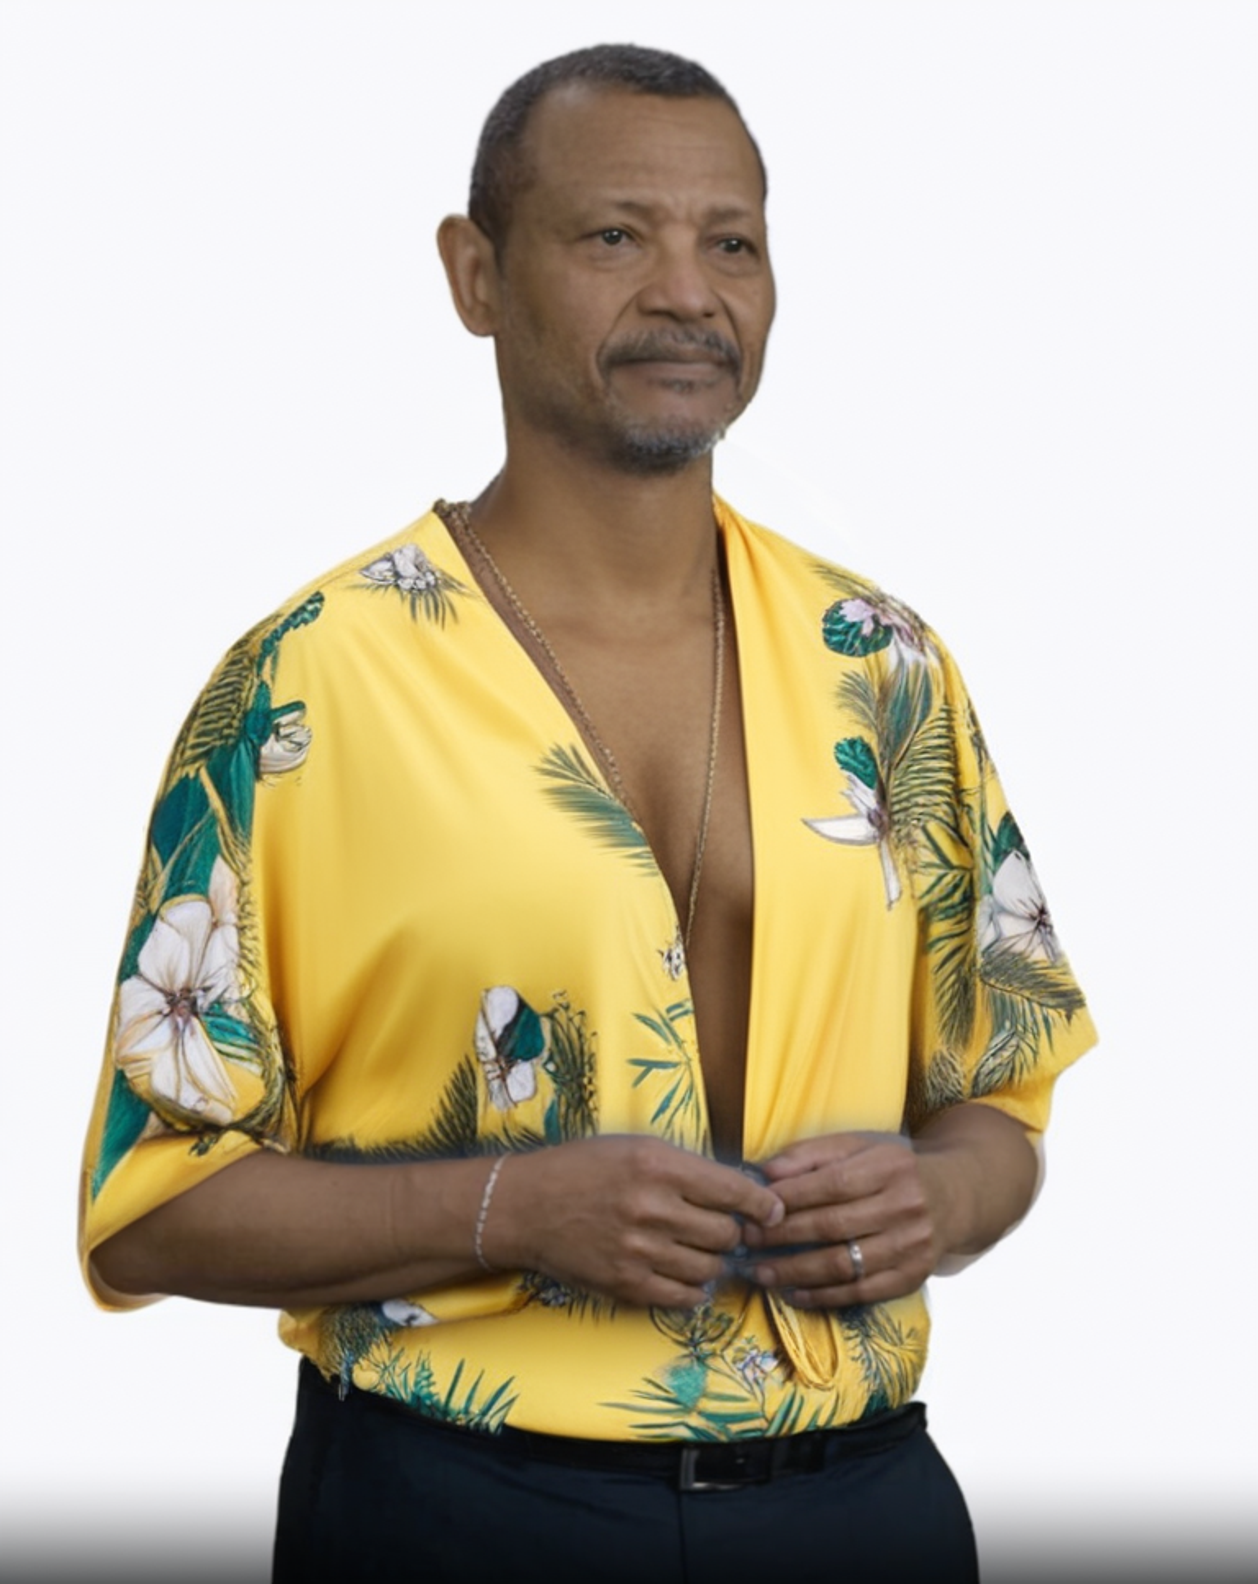

In [68]:
compose_result

In [30]:
def blend_image_with_color(image, mask, color):
    # Convert the mask and image to NumPy arrays
    mask_array = np.array(mask)  # Normalize mask to [0, 1]
    image_array = np.array(image)

    # Create a color array (same size as the image, filled with the target color)
    color_array = np.full_like(image_array, color)

    mask_ex = mask_array[..., None].astype(float) * 0.5

    # Blend the image and the color based on the mask
    blended_array = image_array * (1 - mask_ex) + color_array * mask_ex

    # Convert the result back to a PIL Image
    blended_image = Image.fromarray(np.uint8(blended_array))

    return blended_image


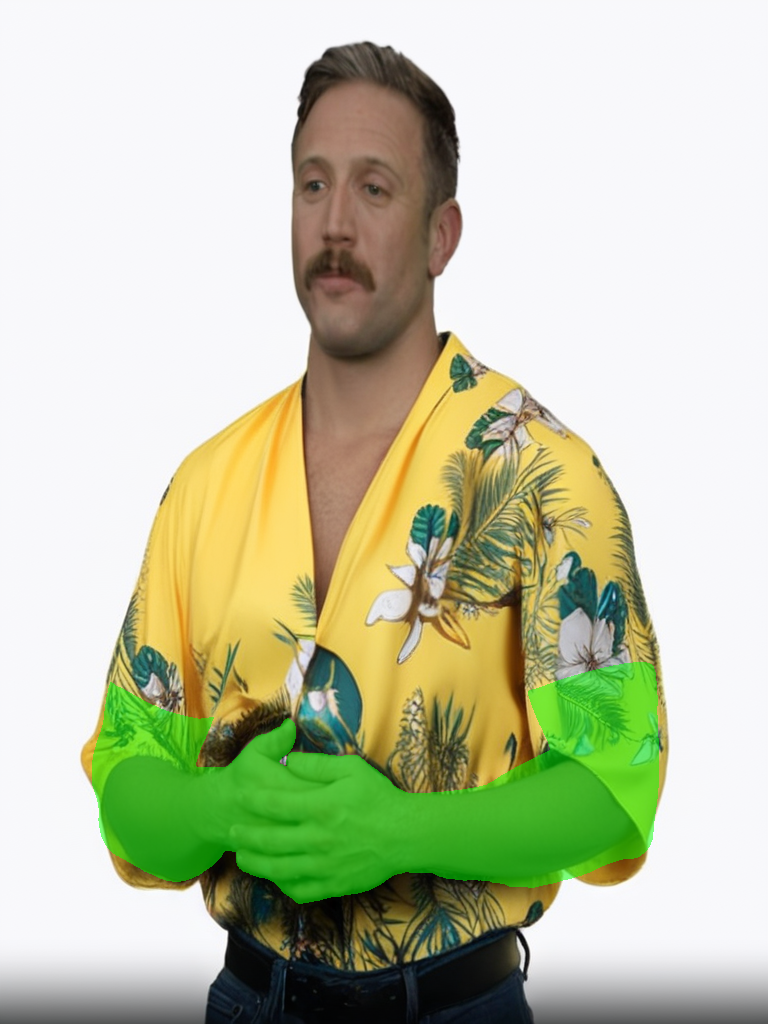

In [31]:
blend_image_with_color(result_image, soft_preservation_submask, (0,255,0))

In [10]:
self.to('cpu')
torch.cuda.empty_cache()

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

In [11]:
init_image=human_img

In [12]:
segmentaion_config = self.segmentaion_config

soft_preservation_submask = extract_submask(
    segmentation_map=init_segmentation_map,
    submask_classes=segmentaion_config['soft_preservation_classes'],
    classes_mapping=init_classes_mapping
)

force_preservetion_submask = extract_submask(
    segmentation_map=init_segmentation_map,
    submask_classes=segmentaion_config['force_preservation_classes'],
    classes_mapping=init_classes_mapping
)

result_segmentation_map, result_classes_mapping = request_segmentation_results(
    url=segmentaion_config['service_url'], 
    image=result_image
)

clothing_submask = extract_submask(
    segmentation_map=result_segmentation_map,
    submask_classes=segmentaion_config['clothing_classes'],
    classes_mapping=result_classes_mapping
)

Loaded as API: http://127.0.0.1:7860/ ✔


In [39]:
from PIL import Image, ImageFilter

In [52]:
clothing_submask_pil = Image.fromarray(clothing_submask)

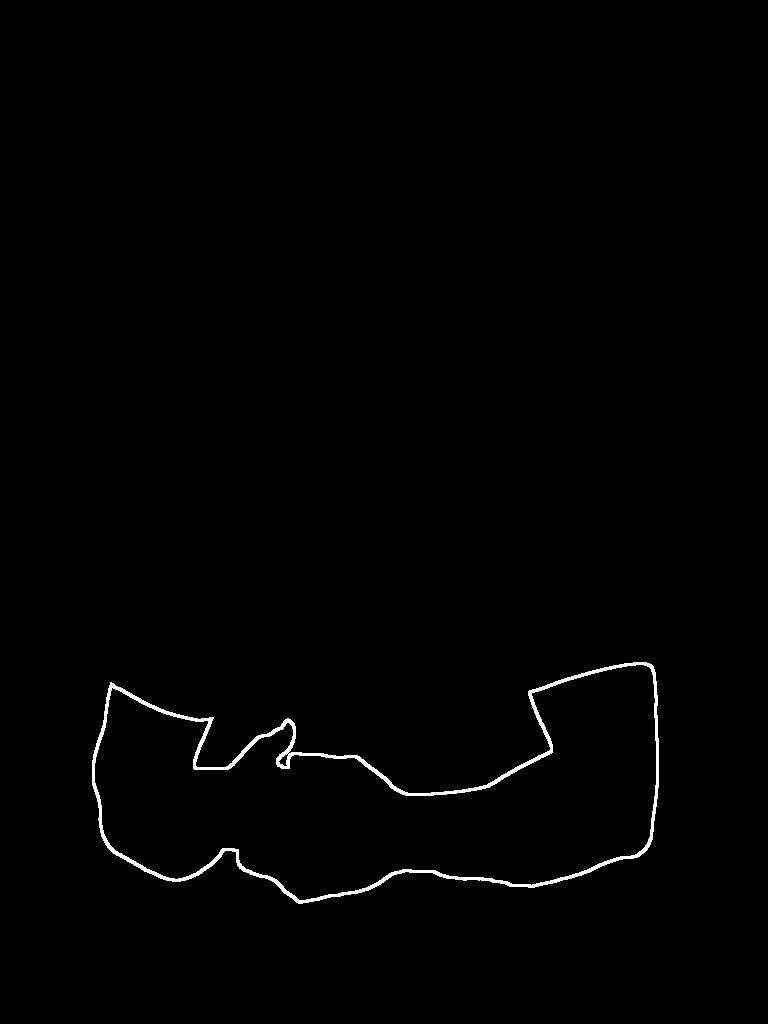

In [61]:
Image.fromarray((soft_preservation_submask.astype(int) - eroded_mask) > 0)